## libraries

In [4]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch

from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    make_scorer,
    f1_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline as hf_pipeline,
    set_seed
)
from datasets import Dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "2"

torch.set_num_threads(2)
set_seed(42)

plt.rcParams["figure.figsize"] = (6, 4)
sns.set(style="whitegrid")


## import dataset

In [5]:
from google.colab import files
uploaded = files.upload()
dual = pd.read_csv('fake_and_real.csv')
dual.info()
print('\nMissing Values')
display(dual.isna().sum())

text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

dup_count_raw = dual.duplicated(subset=text_cols).sum()
print("Exact duplicates (raw text cols):", dup_count_raw)

dual = dual.drop_duplicates(subset=text_cols, keep='first').copy()
print("Shape after dropping exact text duplicates:", dual.shape)


Saving fake_and_real.csv to fake_and_real.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industr

,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


Exact duplicates (raw text cols): 1814
Shape after dropping exact text duplicates: (16066, 18)


# Preprocessing

## handling salary column: min, max, and mean

In [6]:
pat = r'^\s*\$?(\d{2,3}(?:,\d{3})+|\d{4,6})\s*-\s*\$?(\d{2,3}(?:,\d{3})+|\d{4,6})\s*$'

extracted = (
    dual['salary_range'].astype(str)
        .str.extract(pat)                 # two columns: 0=min, 1=max (strings)
        .replace(',', '', regex=True)     # remove commas
        .astype(float)                    # to numeric (NaN where no match)
)

dual[['salary_min', 'salary_max']] = extracted.values
dual['salary_mean'] = dual[['salary_min', 'salary_max']].mean(axis=1)

dual['salary_range_present'] = dual[['salary_min', 'salary_max']].notna().all(axis=1).astype(int)


## handling NAs

In [7]:
dual['salary_mean'].max()

750500.0

In [8]:
del dual['job_id']

print('NA Values')
display(dual.isna().sum())

NA Values


,0
title,0
location,336
department,9943
salary_range,13365
company_profile,3087
description,1
requirements,2302
benefits,6683
telecommuting,0
has_company_logo,0


In [9]:
fill_values = {
    'location': 'Unknown',
    'department': 'Unknown',
    'company_profile': 'Not Provided',
    'description': 'Not Provided',
    'requirements': 'Not Specified',
    'benefits': 'Not Specified',
    'employment_type': 'Unknown',
    'required_experience': 'Not Specified',
    'required_education': 'Not Specified',
    'industry': 'Unknown',
    'function': 'Unknown'
}

dual.fillna(value=fill_values, inplace=True)

print(dual.isna().sum().sort_values(ascending=False))

dual.info()

salary_mean             13776
salary_min              13776
salary_max              13776
salary_range            13365
title                       0
company_profile             0
department                  0
location                    0
description                 0
has_company_logo            0
requirements                0
benefits                    0
telecommuting               0
required_experience         0
employment_type             0
has_questions               0
required_education          0
fraudulent                  0
function                    0
industry                    0
salary_range_present        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 16066 entries, 0 to 17878
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 16066 non-null  object 
 1   location              16066 non-null  object 
 2   department            16066 non-null  object

# Preliminary EDA

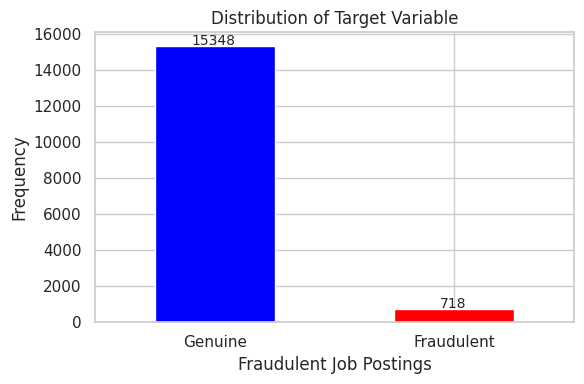

In [10]:
plt.figure(figsize=(6,4))
bar=dual['fraudulent'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target Variable')
plt.xticks([0,1], ['Genuine', 'Fraudulent'], rotation=0)
plt.xlabel('Fraudulent Job Postings')
plt.ylabel('Frequency')
for p in bar.patches:
    height = p.get_height()
    bar.annotate(f'{int(height)}',
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=10, xytext=(-1,-1), textcoords='offset points')

plt.tight_layout()
plt.show()

## Salary Data

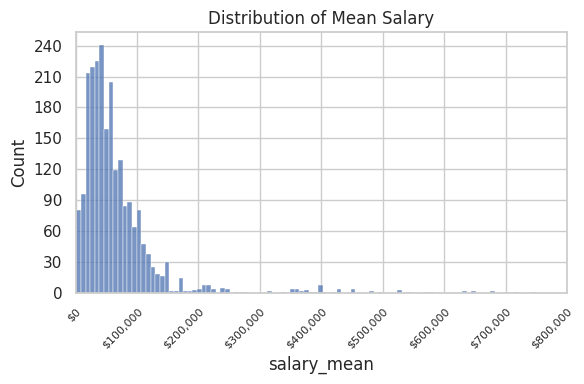

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator

money_fmt = FuncFormatter(lambda x, pos: f'${x:,.0f}')

s = dual['salary_mean']
plt.figure(figsize=(6,4))
ax = sns.histplot(s, edgecolor='white')
plt.xlim(0, 800000)
ax.set_title(f"Distribution of Mean Salary")
ax.set_xlabel('salary_mean')
for lab in ax.get_xticklabels():
    lab.set_rotation(45)
    lab.set_rotation_mode('anchor')
    lab.set_horizontalalignment('right')
    lab.set_fontsize(8)
ax.set_ylabel("Count")
ax.xaxis.set_major_formatter(money_fmt)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

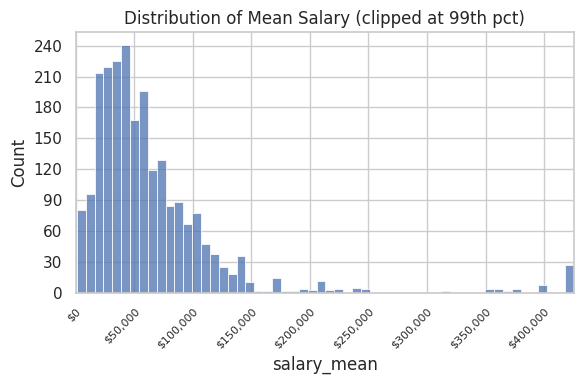

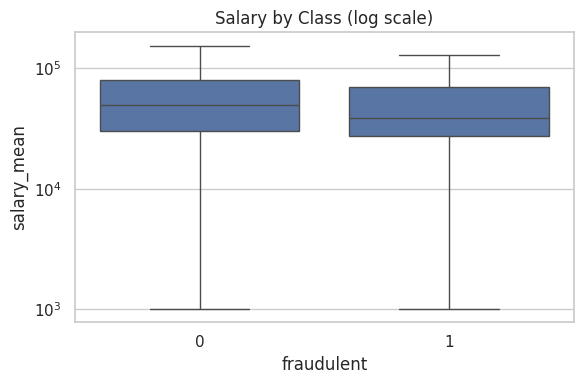

In [12]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
money_fmt = FuncFormatter(lambda x, pos: f'${x:,.0f}')

s = pd.to_numeric(dual['salary_mean'], errors='coerce').dropna()
upper = np.nanpercentile(s, 99)

plt.figure(figsize=(6,4))
ax = sns.histplot(s.clip(upper=upper), edgecolor='white')
ax.set_xlim(0, upper)
ax.set_title("Distribution of Mean Salary (clipped at 99th pct)")
ax.set_xlabel('salary_mean'); ax.set_ylabel("Count")
ax.xaxis.set_major_formatter(money_fmt)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for lab in ax.get_xticklabels():
    lab.set_rotation(45)
    lab.set_rotation_mode('anchor')
    lab.set_horizontalalignment('right')
    lab.set_fontsize(8)
plt.tight_layout(); plt.show()

sns.boxplot(x='fraudulent', y='salary_mean', data=dual, showfliers=False)
plt.yscale('log'); plt.title('Salary by Class (log scale)'); plt.tight_layout(); plt.show()


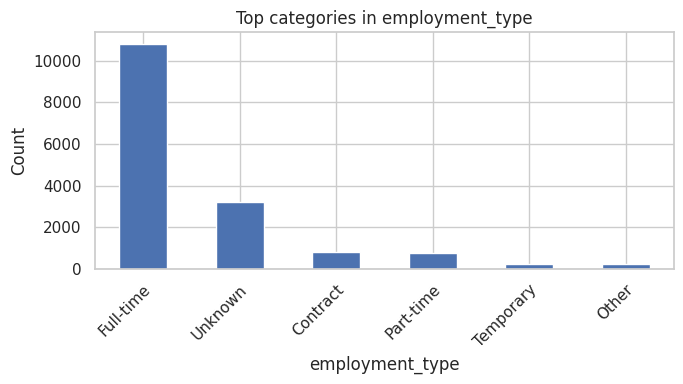

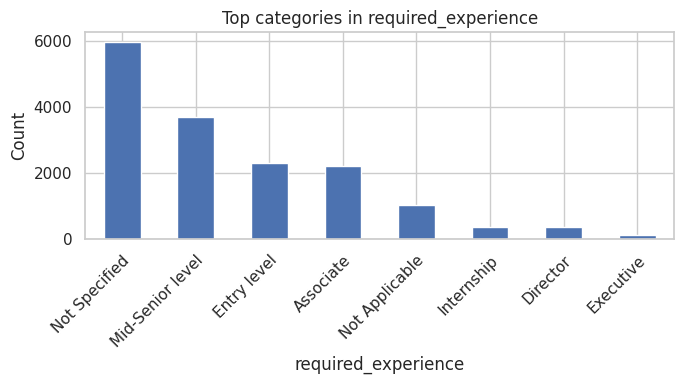

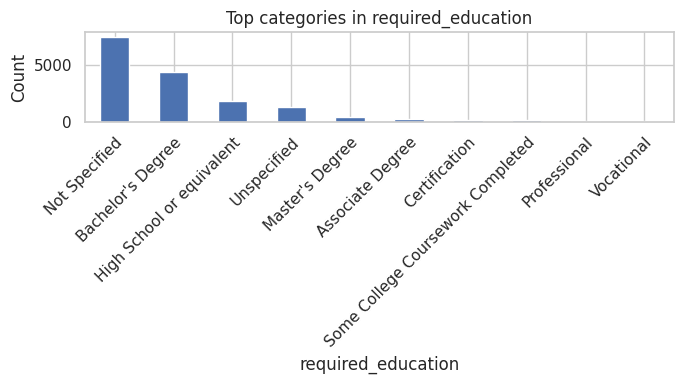

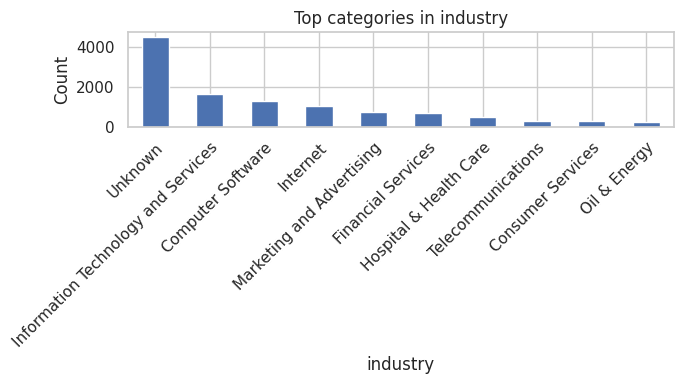

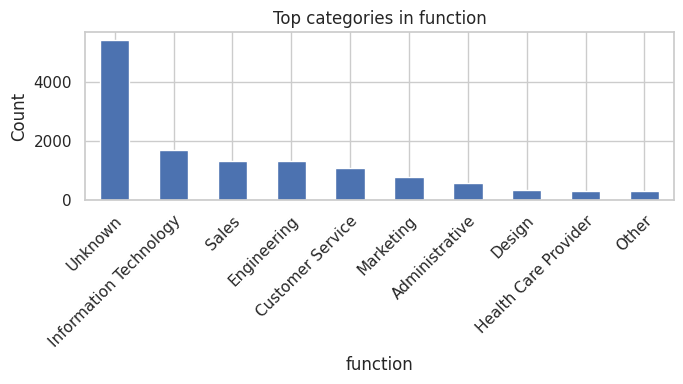

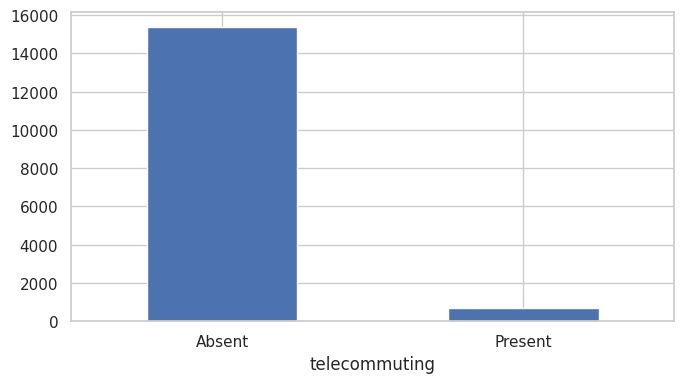

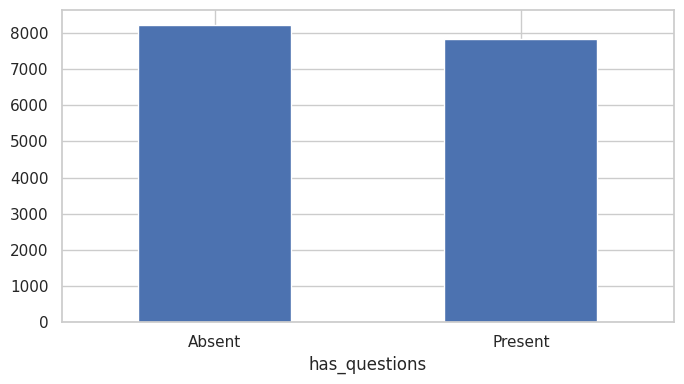

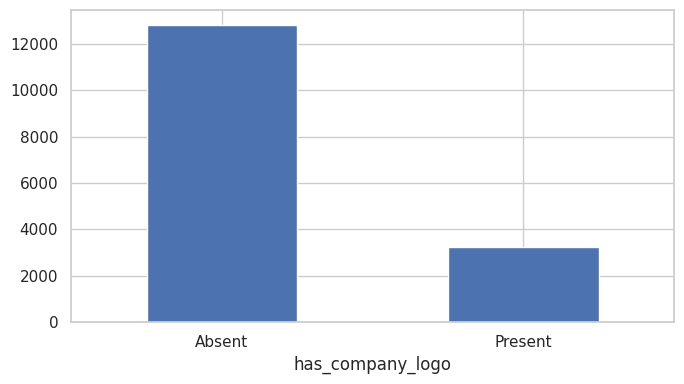

In [13]:
import matplotlib.pyplot as plt

for col in ['employment_type', 'required_experience', 'required_education', 'industry',
            'function']:
    counts = dual[col].value_counts().head(10)
    fig, ax = plt.subplots(figsize=(7,4))
    counts.plot(kind='bar', ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(f'Top categories in {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    fig.tight_layout()
    plt.show()


for col in ['telecommuting','has_questions', 'has_company_logo']:
    counts=dual[col].value_counts()
    fig,ax = plt.subplots(figsize=(7,4))
    counts.plot(kind='bar', ax=ax)
    plt.xticks([0, 1], ['Absent', 'Present'], rotation=0)
    fig.tight_layout()
    plt.show()



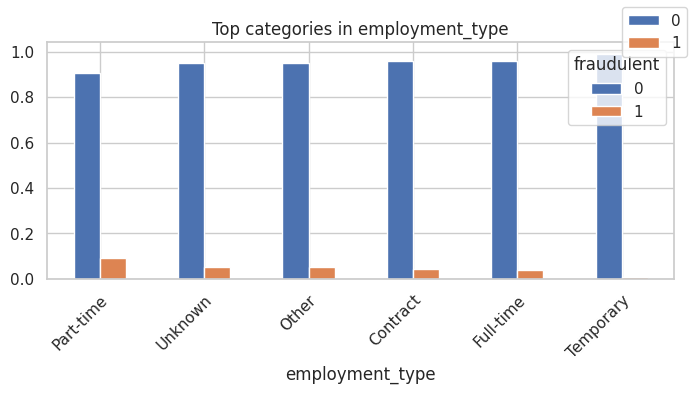

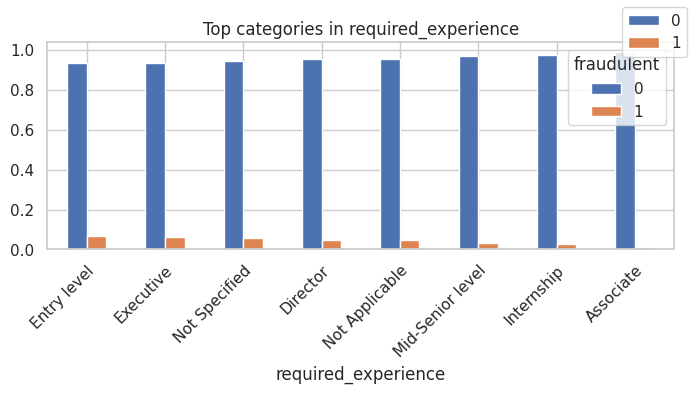

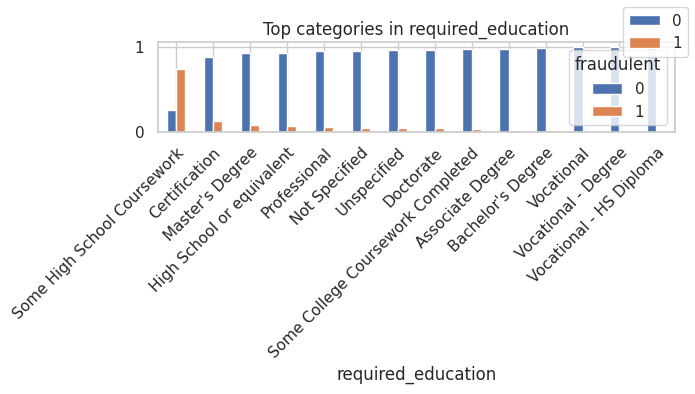

In [14]:

for col in ['employment_type', 'required_experience', 'required_education']:
    counts = pd.crosstab(dual[col], dual['fraudulent'], normalize='index').sort_values(by=1, ascending=False)
    fig,ax = plt.subplots(figsize=(7,4))
    counts.plot(kind='bar', ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    fig.legend(loc='outside upper right')
    ax.set_title(f'Top categories in {col}')
    ax.set_xlabel(col)
    fig.tight_layout()
    plt.show()



<Axes: xlabel='fraudulent', ylabel='salary_mean'>

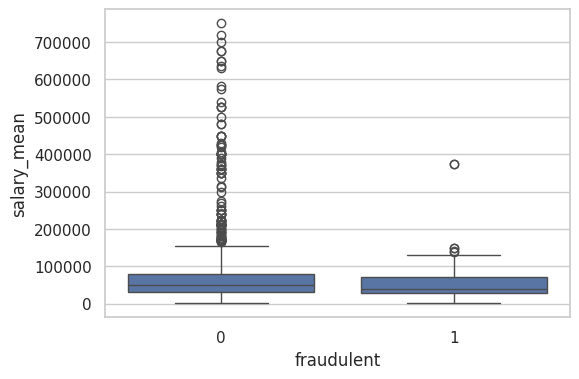

In [15]:
sns.boxplot(x='fraudulent', y='salary_mean', data=dual)

In [16]:
dual.head(10).T

,0,1,2,3,4,5,6,7,8,9
title,Marketing Intern,Customer Service - Cloud Video Production,Commissioning Machinery Assistant (CMA),Account Executive - Washington DC,Bill Review Manager,Accounting Clerk,Head of Content (m/f),Lead Guest Service Specialist,HP BSM SME,Customer Service Associate - Part Time
location,"US, NY, New York","NZ, , Auckland","US, IA, Wever","US, DC, Washington","US, FL, Fort Worth","US, MD,","DE, BE, Berlin","US, CA, San Francisco","US, FL, Pensacola","US, AZ, Phoenix"
department,Marketing,Success,Unknown,Sales,Unknown,Unknown,ANDROIDPIT,Unknown,Unknown,Unknown
salary_range,NaN,NaN,NaN,NaN,NaN,NaN,20000-28000,NaN,NaN,NaN
company_profile,"We're Food52, and we've created a groundbreaki...","90 Seconds, the worlds Cloud Video Production ...",Valor Services provides Workforce Solutions th...,Our passion for improving quality of life thro...,SpotSource Solutions LLC is a Global Human Cap...,Not Provided,"Founded in 2009, the Fonpit AG rose with its i...",Airenvy’s mission is to provide lucrative yet ...,Solutions3 is a woman-owned small business who...,"Novitex Enterprise Solutions, formerly Pitney ..."
description,"Food52, a fast-growing, James Beard Award-winn...",Organised - Focused - Vibrant - Awesome!Do you...,"Our client, located in Houston, is actively se...",THE COMPANY: ESRI – Environmental Systems Rese...,JOB TITLE: Itemization Review ManagerLOCATION:...,Job OverviewApex is an environmental consultin...,Your Responsibilities: Manage the English-spea...,Who is Airenvy?Hey there! We are seasoned entr...,Implementation/Configuration/Testing/Training ...,The Customer Service Associate will be based i...
requirements,Experience with content management systems a m...,What we expect from you:Your key responsibilit...,Implement pre-commissioning and commissioning ...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",QUALIFICATIONS:RN license in the State of Texa...,Not Specified,Your Know-How: ...,"Experience with CRM software, live chat, and p...",MUST BE A US CITIZEN.An active TS/SCI clearanc...,Minimum Requirements:Minimum of 6 months custo...
benefits,Not Specified,What you will get from usThrough being part of...,Not Specified,Our culture is anything but corporate—we have ...,Full Benefits Offered,Not Specified,Your Benefits: Being part of a fast-growing co...,Competitive Pay. You'll be able to eat steak e...,Not Specified,Not Specified
telecommuting,0,0,0,0,0,0,0,0,0,0
has_company_logo,1,1,1,1,1,0,1,1,1,1


# Text Preprocessing

In [17]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

dual_text = dual.loc[:, text_cols].fillna('').astype(str).copy()

from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english')) | {"amp", "nbsp"}
stop_words.discard("not")

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag: str):
    if   tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)   # keep spaces so tokens don’t merge
    tokens = [t for t in word_tokenize(text) if t not in stop_words and t.strip()]
    tagged  = pos_tag(tokens)
    lemmas  = [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]
    return ' '.join(lemmas)

for col in text_cols:
    dual_text[col] = dual_text[col].apply(preprocess_text)

for col in text_cols:
    dual[f'{col}_clean'] = dual_text[col]

dual['text_all_clean'] = dual[[f'{c}_clean' for c in text_cols]].agg(' '.join, axis=1)


# Train Test Stratify Split

In [18]:
text_cols = ['title_clean','company_profile_clean','description_clean','requirements_clean','benefits_clean']
dual['text_all'] = dual[text_cols].fillna('').agg(' '.join, axis=1)

dual_unique = dual.drop_duplicates(subset=['text_all']).copy().reset_index(drop=True)

num_cols = ['salary_mean']
bin_cols = ['salary_range_present','telecommuting','has_questions','has_company_logo']
y = dual_unique['fraudulent'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    dual_unique[['text_all']+num_cols+bin_cols], y, test_size=0.3, stratify=y, random_state=42
)

In [19]:
print("Train class balance:\n", y_train.value_counts(normalize=True).round(3))
print("Test  class balance:\n", y_test.value_counts(normalize=True).round(3))

Train class balance:
 fraudulent
0    0.955
1    0.045
Name: proportion, dtype: float64
Test  class balance:
 fraudulent
0    0.955
1    0.045
Name: proportion, dtype: float64


### TFIDF

In [33]:
NG = (3, 3)
MIN_DF = 3
STOP = 'english'
N_TOP = 20

tfidf = TfidfVectorizer(ngram_range=NG, min_df=MIN_DF, stop_words=STOP, sublinear_tf=True)
Xtr = tfidf.fit_transform(X_train['text_all'])
Xte = tfidf.transform(X_test['text_all'])

terms = np.array(tfidf.get_feature_names_out())
avg_w = Xtr.mean(axis=0).A1
top_tfidf = (
    pd.DataFrame({'ngram': terms, 'avg_tfidf': avg_w})
      .sort_values('avg_tfidf', ascending=False)
      .head(N_TOP)
)
print("\nTop n-grams by avg TF-IDF:")
print(top_tfidf)


Top n-grams by avg TF-IDF:
                                      ngram  avg_tfidf
615                             18 year old   0.002599
143919              time permanent position   0.002570
112693               provide time permanent   0.002509
101824            permanent position medium   0.002509
105041                position medium large   0.002509
87278                  medium large company   0.002509
150634           verbal write communication   0.002447
157633           write verbal communication   0.002427
49813         excellent communication skill   0.002405
89018               minimum year experience   0.002405
141109              technical non technical   0.002322
576                              16 18 year   0.002322
157401            write communication skill   0.002247
64914                high quality candidate   0.002149
65000                   high school diploma   0.002143
65324                  highly technical non   0.002103
18281   candidate engineering manufac

# Baseline Performance Prior to Augmentation

### Multinomial NB, Logistic Regression, SVM, Decision Trees Pipelines

In [21]:
X_train_text = X_train["text_all"]
X_test_text  = X_test["text_all"]

f1_fraud_scorer = make_scorer(f1_score, pos_label=1)

tfidf_tri = TfidfVectorizer(
    ngram_range=(3, 3),
    min_df=3,
    stop_words='english',
    sublinear_tf=True
)

nb_base = Pipeline([
    ("tfidf", tfidf_tri),
    ("clf", MultinomialNB(alpha=0.5))
])

lr_base = Pipeline([
    ("tfidf", tfidf_tri),
    ("clf", LogisticRegression(max_iter=1000))
])

svm_base = Pipeline([
    ("tfidf", tfidf_tri),
    ("clf", SVC(kernel='linear', probability=True))
])

dt_base = Pipeline([
    ("tfidf", tfidf_tri),
    ("clf", DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=20,
        random_state=42))
])

models_base = {
    "NB_baseline": {
        "pipe": nb_base,
        "X_train": X_train_text,
        "y_train": y_train,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "baseline_text"
    },
    "LR_baseline": {
        "pipe": lr_base,
        "X_train": X_train_text,
        "y_train": y_train,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "baseline_text"
    },
    "SVM_baseline": {
        "pipe": svm_base,
        "X_train": X_train_text,
        "y_train": y_train,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "baseline_text"
    },
    "DT_baseline": {
        "pipe": dt_base,
        "X_train": X_train_text,
        "y_train": y_train,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "baseline_text"
    }
}

rows = []

for name, cfg in models_base.items():
    pipe   = cfg["pipe"]
    X_tr   = cfg["X_train"]
    y_tr   = cfg["y_train"]
    X_te   = cfg["X_test"]
    y_te   = cfg["y_test"]
    group  = cfg["group"]

    print(f'\nFitting {name}...')
    pipe.fit(X_tr, y_tr)

    y_pred_tr = pipe.predict(X_tr)
    y_pred_te = pipe.predict(X_te)
    acc = accuracy_score(y_te, y_pred_te)

    print("\n" + "-"*70)
    print("Accuracy Summary (Test Set)")
    print("-"*70)
    print(f"{name:20s}: {acc:.4f}")

    print("\n" + "="*70)
    print(f"MODEL: {name} – TRAINING SET")
    print("="*70)
    print(classification_report(
        y_tr,
        y_pred_tr,
        target_names=['genuine (0)', 'fraudulent (1)'],
        digits=4
    ))

    print("\n" + "="*70)
    print(f"MODEL: {name} – TEST SET")
    print("="*70)
    print(classification_report(
        y_te,
        y_pred_te,
        target_names=['genuine (0)', 'fraudulent (1)'],
        digits=4
    ))

    acc_tr = accuracy_score(y_tr, y_pred_tr)
    prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
        y_tr, y_pred_tr, average='binary', pos_label=1
    )

    rows.append({
        "model": name,
        "group": group,
        "set": "train",
        "accuracy": acc_tr,
        "precision_fraud": prec_tr,
        "recall_fraud": rec_tr,
        "f1_fraud": f1_tr
    })
    # ---- STORE TEST METRICS (fraud class) ----
    acc_te = accuracy_score(y_te, y_pred_te)
    prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
        y_te, y_pred_te, average='binary', pos_label=1
    )

    rows.append({
        "model": name,
        "group": group,
        "set": "test",
        "accuracy": acc_te,
        "precision_fraud": prec_te,
        "recall_fraud": rec_te,
        "f1_fraud": f1_te
    })

results_base_df = (
    pd.DataFrame(rows)
      .sort_values(by=["group", "model", "set"])
)



Fitting NB_baseline...

----------------------------------------------------------------------
Accuracy Summary (Test Set)
----------------------------------------------------------------------
NB_baseline         : 0.9585

MODEL: NB_baseline – TRAINING SET
                precision    recall  f1-score   support

   genuine (0)     0.9843    0.9707    0.9775     10523
fraudulent (1)     0.5188    0.6707    0.5850       495

      accuracy                         0.9573     11018
     macro avg     0.7515    0.8207    0.7812     11018
  weighted avg     0.9634    0.9573    0.9598     11018


MODEL: NB_baseline – TEST SET
                precision    recall  f1-score   support

   genuine (0)     0.9776    0.9789    0.9783      4510
fraudulent (1)     0.5388    0.5236    0.5311       212

      accuracy                         0.9585      4722
     macro avg     0.7582    0.7513    0.7547      4722
  weighted avg     0.9579    0.9585    0.9582      4722


Fitting LR_baseline...

-------

In [22]:
dt_cfg = models_base["DT_baseline"]
dt_pipe = dt_cfg["pipe"]

dt_pipe.fit(dt_cfg["X_train"], dt_cfg["y_train"])

dt_model = dt_pipe.named_steps["clf"]

print("Decision Tree structure (DT_baseline):")
print("Depth (get_depth):        ", dt_model.get_depth())
print("Number of leaves:         ", dt_model.get_n_leaves())
print("Tree depth (tree_.max_depth):", dt_model.tree_.max_depth)
print("Number of nodes:          ", dt_model.tree_.node_count)


Decision Tree structure (DT_baseline):
Depth (get_depth):         20
Number of leaves:          25
Tree depth (tree_.max_depth): 20
Number of nodes:           49


Train mean F1: [0.9        0.80549108 0.77070048 0.73587521 0.72446916]
Test mean F1 : [0.37126543 0.60034165 0.63578621 0.63170569 0.65425282]


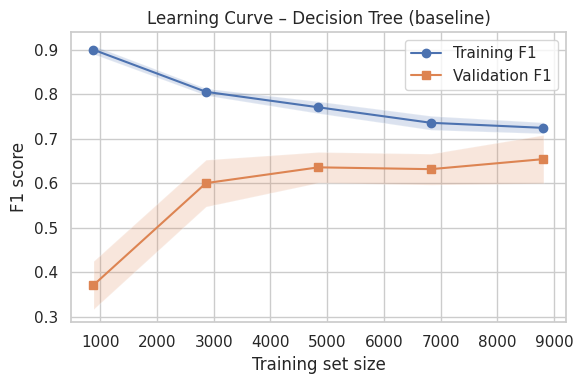

In [23]:
train_sizes, train_scores, test_scores = learning_curve(
    dt_base,
    X_train_text,
    y_train,
    cv=5,
    n_jobs=-1
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=dt_base,
    X=X_train_text,
    y=y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="f1"
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

print("Train mean F1:", train_mean)
print("Test mean F1 :", test_mean)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker="o", label="Training F1")
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.2)

plt.plot(train_sizes, test_mean, marker="s", label="Validation F1")
plt.fill_between(train_sizes,
                 test_mean - test_std,
                 test_mean + test_std,
                 alpha=0.2)

plt.title("Learning Curve – Decision Tree (baseline)")
plt.xlabel("Training set size")
plt.ylabel("F1 score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Tuning Baseline Models

In [24]:
param_grid_nb = {
    "clf__alpha": [0.1, 0.5, 1.0]
}

param_grid_lr = {
    "clf__C": [0.1, 1.0, 10.0],
    "clf__class_weight": [None, "balanced"]
}

param_grid_svm = {
    "clf__C": [0.1, 1.0, 10.0],
    "clf__class_weight": [None, "balanced"]
}

param_grid_dt = {
    "clf__max_depth": [5, 10, 20],
    "clf__min_samples_split": [5, 10, 20]
}

gs_nb = GridSearchCV(
    nb_base,
    param_grid_nb,
    scoring=f1_fraud_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)
gs_nb.fit(X_train_text, y_train)

gs_lr = GridSearchCV(
    lr_base,
    param_grid_lr,
    scoring=f1_fraud_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)
gs_lr.fit(X_train_text, y_train)

gs_svm = GridSearchCV(
    svm_base,
    param_grid_svm,
    scoring=f1_fraud_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)
gs_svm.fit(X_train_text, y_train)

gs_dt = GridSearchCV(
    dt_base,
    param_grid_dt,
    scoring=f1_fraud_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)
gs_dt.fit(X_train_text, y_train)

best_nb  = gs_nb.best_estimator_
best_lr  = gs_lr.best_estimator_
best_svm = gs_svm.best_estimator_
best_dt  = gs_dt.best_estimator_

rows_gs = []

for name, model in [
    ("NB_tuned",  best_nb),
    ("LR_tuned",  best_lr),
    ("SVM_tuned", best_svm),
    ("DT_tuned",  best_dt)
]:
    y_pred_tr = model.predict(X_train_text)
    y_pred_te = model.predict(X_test_text)

    print("\n" + "="*70)
    print(f"MODEL: {name} – TRAINING SET (tuned)")
    print("="*70)
    print(classification_report(
        y_train,
        y_pred_tr,
        target_names=["genuine (0)", "fraudulent (1)"],
        digits=4
    ))

    print("\n" + "="*70)
    print(f"MODEL: {name} – TEST SET (tuned)")
    print("="*70)
    print(classification_report(
        y_test,
        y_pred_te,
        target_names=["genuine (0)", "fraudulent (1)"],
        digits=4
    ))

    acc_tr = accuracy_score(y_train, y_pred_tr)
    prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
        y_train, y_pred_tr, average='binary', pos_label=1
    )

    rows_gs.append({
        "model": name,
        "group": "baseline_text_tuned",
        "set": "train",
        "accuracy": acc_tr,
        "precision_fraud": prec_tr,
        "recall_fraud": rec_tr,
        "f1_fraud": f1_tr
    })

    acc_te = accuracy_score(y_test, y_pred_te)
    prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
        y_test, y_pred_te, average='binary', pos_label=1
    )

    rows_gs.append({
        "model": name,
        "group": "baseline_text_tuned",
        "set": "test",
        "accuracy": acc_te,
        "precision_fraud": prec_te,
        "recall_fraud": rec_te,
        "f1_fraud": f1_te
    })

results_gs_df = (
    pd.DataFrame(rows_gs)
      .sort_values(by=["group", "model", "set"])
)

baseline_models = pd.concat(
    [results_base_df, results_gs_df],
    ignore_index=True
)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits

MODEL: NB_tuned – TRAINING SET (tuned)
                precision    recall  f1-score   support

   genuine (0)     0.9788    0.9909    0.9848     10523
fraudulent (1)     0.7370    0.5434    0.6256       495

      accuracy                         0.9708     11018
     macro avg     0.8579    0.7672    0.8052     11018
  weighted avg     0.9679    0.9708    0.9687     11018


MODEL: NB_tuned – TEST SET (tuned)
                precision    recall  f1-score   support

   genuine (0)     0.9762    0.9922    0.9842      4510
fraudulent (1)     0.7464    0.4858    0.5886       212

      accuracy                         0.9695      4722
     macro avg     0.8613    0.7390    0.7864      4722
  weighted avg     0.9659    0.9695    0.9664      4722


MODEL:

### BERT

In [25]:
from transformers import EarlyStoppingCallback

RS = 42

train_df = pd.DataFrame({
    "text": X_train["text_all"].astype(str).values,
    "label": y_train.astype(int).values
})

test_df = pd.DataFrame({
    "text": X_test["text_all"].astype(str).values,
    "label": y_test.astype(int).values
})

ds_train = Dataset.from_pandas(train_df, preserve_index=False)
ds_eval  = Dataset.from_pandas(test_df,  preserve_index=False)

model_name = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

ds_train_tok = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
ds_eval_tok  = ds_eval.map(tokenize_fn,  batched=True, remove_columns=["text"])

from datasets import Value
ds_train_tok = ds_train_tok.cast_column("label", Value("int64"))
ds_eval_tok  = ds_eval_tok.cast_column("label",  Value("int64"))

collator = DataCollatorWithPadding(tokenizer=tokenizer)

import evaluate
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
    }
args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_eval_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
eval_res = trainer.evaluate()
print("Eval metrics:", eval_res)

train_pred_out = trainer.predict(ds_train_tok)
y_train_pred   = train_pred_out.predictions.argmax(axis=-1)
y_train_true   = train_df["label"].to_numpy()

test_pred_out  = trainer.predict(ds_eval_tok)
y_test_pred    = test_pred_out.predictions.argmax(axis=-1)
y_test_true    = test_df["label"].to_numpy()

print("\n" + "="*70)
print("BERT_baseline – TRAINING SET")
print("="*70)
print(classification_report(
    y_train_true,
    y_train_pred,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

print("\n" + "="*70)
print("BERT_baseline – TEST SET")
print("="*70)
print(classification_report(
    y_test_true,
    y_test_pred,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

rows_bert = []

acc_tr = accuracy_score(y_train_true, y_train_pred)
prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
    y_train_true, y_train_pred, average='binary', pos_label=1
)

rows_bert.append({
    "model": "BERT_baseline",
    "group": "bert_baseline",
    "set": "train",
    "accuracy": acc_tr,
    "precision_fraud": prec_tr,
    "recall_fraud": rec_tr,
    "f1_fraud": f1_tr
})

acc_te = accuracy_score(y_test_true, y_test_pred)
prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
    y_test_true, y_test_pred, average='binary', pos_label=1
)

rows_bert.append({
    "model": "BERT_baseline",
    "group": "bert_baseline",
    "set": "test",
    "accuracy": acc_te,
    "precision_fraud": prec_te,
    "recall_fraud": rec_te,
    "f1_fraud": f1_te
})

bert_results_df = (
    pd.DataFrame(rows_bert)
      .sort_values(by=["group", "model", "set"])
)

all_models_df = pd.concat(
    [baseline_models, bert_results_df],
    ignore_index=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11018 [00:00<?, ? examples/s]

Map:   0%|          | 0/4722 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/11018 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4722 [00:00<?, ? examples/s]

/tmp/ipython-input-2618049267.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.116800,0.081768,0.976069,0.693767
2,0.030200,0.083471,0.982423,0.770083
3,0.009800,0.072342,0.982423,0.799031


Eval metrics: {'eval_loss': 0.07234248518943787, 'eval_accuracy': 0.9824227022448115, 'eval_f1': 0.7990314769975787, 'eval_runtime': 33.9132, 'eval_samples_per_second': 139.238, 'eval_steps_per_second': 8.728, 'epoch': 3.0}



BERT_baseline – TRAINING SET
                precision    recall  f1-score   support

   genuine (0)     0.9979    0.9989    0.9984     10523
fraudulent (1)     0.9753    0.9556    0.9653       495

      accuracy                         0.9969     11018
     macro avg     0.9866    0.9772    0.9818     11018
  weighted avg     0.9969    0.9969    0.9969     11018


BERT_baseline – TEST SET
                precision    recall  f1-score   support

   genuine (0)     0.9896    0.9920    0.9908      4510
fraudulent (1)     0.8209    0.7783    0.7990       212

      accuracy                         0.9824      4722
     macro avg     0.9052    0.8852    0.8949      4722
  weighted avg     0.9820    0.9824    0.9822      4722



# Handling Class Imbalance

In [26]:
from transformers import AutoTokenizer, pipeline

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

fraud_train = X_train.loc[y_train == 1, "text_all"].reset_index(drop=True)
gen_train   = X_train.loc[y_train == 0, "text_all"].reset_index(drop=True)

n_min = len(fraud_train)
n_maj = len(gen_train)

target_min = int(n_maj * 0.3)
n_synth = max(0, target_min - n_min)

gen = pipeline(
    "text-generation",
    model=model_name,
    device=0,
    max_new_tokens=80,
    do_sample=True,
    top_p=0.9,
    temperature=0.8,
)

from tqdm.auto import trange

max_prompt_tokens = 900
synthetic_texts = []
seed_idx = 0

for i in trange(n_synth):
    seed = fraud_train.iloc[seed_idx]
    seed_idx = (seed_idx + 1) % n_min

    enc = tokenizer(
        seed,
        truncation=True,
        max_length=max_prompt_tokens,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    seed_trimmed = tokenizer.decode(enc["input_ids"], skip_special_tokens=True)

    prompt = (
        "Write a fraudulent online job posting similar to the one below. "
        "Keep the style and approximate length similar.\n\n"
        "Example fake job posting:\n"
        f"{seed_trimmed}\n\n"
        "New fake job posting:\n"
    )

    out = gen(prompt, num_return_sequences=1)[0]["generated_text"]

    if "New fake job posting:" in out:
        new_text = out.split("New fake job posting:")[-1].strip()
    else:
        new_text = out.strip()

    synthetic_texts.append(new_text)

len(synthetic_texts)



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


  0%|          | 0/2661 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `

2661

In [27]:
aug_train_df = pd.DataFrame({
    "text_all": pd.concat(
        [X_train["text_all"].reset_index(drop=True),
         pd.Series(synthetic_texts, name="text_all")],
        ignore_index=True
    ),
    "label": pd.concat(
        [y_train.reset_index(drop=True),
         pd.Series([1] * len(synthetic_texts), name="label")],
        ignore_index=True
    )
})

print(aug_train_df["label"].value_counts())


label
0    0.769281
1    0.230719
Name: proportion, dtype: float64


# Augmented Dataset Performance

## Multinomial NB, Logistic Regression, SVM, Decision Tree

In [28]:
X_train_aug = aug_train_df['text_all']
y_train_aug = aug_train_df['label']

X_test_text = X_test["text_all"]
y_test_vec  = y_test.values


models_aug = {

    "NB_aug": {
        "pipe": best_nb,
        "X_train": X_train_aug,
        "y_train": y_train_aug,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "aug_text"
    },
    "LR_aug": {
        "pipe": best_lr,
        "X_train": X_train_aug,
        "y_train": y_train_aug,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "aug_text"
    },
    "SVM_aug": {
        "pipe": best_svm,
        "X_train": X_train_aug,
        "y_train": y_train_aug,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "aug_text"
    },
    "DT_aug": {
        "pipe": best_dt,
        "X_train": X_train_aug,
        "y_train": y_train_aug,
        "X_test": X_test_text,
        "y_test": y_test,
        "group": "aug_text"
    }}

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

rows = []

for name, cfg in models_aug.items():
    pipe   = cfg["pipe"]
    X_tr   = cfg["X_train"]
    y_tr   = cfg["y_train"]
    X_te   = cfg["X_test"]
    y_te   = cfg["y_test"]
    group  = cfg["group"]

    print(f'\nFitting {name}...')

    pipe.fit(X_tr, y_tr)

    y_pred_tr = pipe.predict(X_tr)
    y_pred_te = pipe.predict(X_te)

    print("\n" + "-"*70)
    print("Accuracy Summary (Test Set)")
    print("-"*70)
    print(f"{name:20s}: {acc:.4f}")

    print("\n" + "="*70)
    print(f"MODEL: {name} – TRAINING SET")
    print("="*70)
    print(classification_report(
        y_tr,
        y_pred_tr,
        target_names=['genuine (0)', 'fraudulent (1)'],
        digits=4
    ))

    print("\n" + "="*70)
    print(f"MODEL: {name} – TEST SET")
    print("="*70)
    print(classification_report(
        y_te,
        y_pred_te,
        target_names=['genuine (0)', 'fraudulent (1)'],
        digits=4
    ))

    acc_tr = accuracy_score(y_tr, y_pred_tr)
    prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
        y_tr, y_pred_tr, average='binary', pos_label=1
    )

    rows.append({
        "model": name,
        "group": group,
        "set": "train",
        "accuracy": acc_tr,
        "precision_fraud": prec_tr,
        "recall_fraud": rec_tr,
        "f1_fraud": f1_tr
    })

    acc_te = accuracy_score(y_te, y_pred_te)
    prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
        y_te, y_pred_te, average='binary', pos_label=1
    )

    rows.append({
        "model": name,
        "group": group,
        "set": "test",
        "accuracy": acc_te,
        "precision_fraud": prec_te,
        "recall_fraud": rec_te,
        "f1_fraud": f1_te
    })

results_aug_df = (
    pd.DataFrame(rows)
      .sort_values(by=["group", "model", "set"])
)

all_models_df = pd.concat(
    [results_base_df, results_gs_df, results_aug_df, bert_results_df],
    ignore_index=True
)



Fitting NB_aug...

----------------------------------------------------------------------
Accuracy Summary (Test Set)
----------------------------------------------------------------------
NB_aug              : 0.9790

MODEL: NB_aug – TRAINING SET
                precision    recall  f1-score   support

   genuine (0)     0.9864    0.9864    0.9864     10523
fraudulent (1)     0.9547    0.9547    0.9547      3156

      accuracy                         0.9791     13679
     macro avg     0.9706    0.9706    0.9706     13679
  weighted avg     0.9791    0.9791    0.9791     13679


MODEL: NB_aug – TEST SET
                precision    recall  f1-score   support

   genuine (0)     0.9861    0.9900    0.9881      4510
fraudulent (1)     0.7680    0.7028    0.7340       212

      accuracy                         0.9771      4722
     macro avg     0.8771    0.8464    0.8610      4722
  weighted avg     0.9763    0.9771    0.9766      4722


Fitting LR_aug...

---------------------------

## BERT

In [29]:

train_df_aug = pd.DataFrame({
    "text": aug_train_df["text_all"].astype(str).values,
    "label": aug_train_df["label"].astype(int).values
})

test_df = pd.DataFrame({   # same test set as before
    "text": X_test["text_all"].astype(str).values,
    "label": y_test.astype(int).values
})

ds_train_aug = Dataset.from_pandas(train_df_aug, preserve_index=False)
ds_eval  = Dataset.from_pandas(test_df,      preserve_index=False)

bert_aug_name = "bert-base-uncased"
tokenizer_aug = AutoTokenizer.from_pretrained(bert_aug_name)
model_aug     = AutoModelForSequenceClassification.from_pretrained(
    bert_aug_name,
    num_labels=2
)

def tokenize_fn_aug(batch):
    return tokenizer_aug(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

ds_train_aug_tok = ds_train_aug.map(tokenize_fn_aug, batched=True, remove_columns=["text"])
ds_eval_tok      = ds_eval.map(tokenize_fn_aug,      batched=True, remove_columns=["text"])

from datasets import Value
ds_train_aug_tok = ds_train_aug_tok.cast_column("label", Value("int64"))
ds_eval_tok      = ds_eval_tok.cast_column("label",   Value("int64"))

collator_aug = DataCollatorWithPadding(tokenizer=tokenizer_aug)

import evaluate
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics_aug(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
    }

args_aug = TrainingArguments(
    output_dir="./bert_results_aug",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    report_to="none"
)

trainer_aug = Trainer(
    model=model_aug,
    args=args_aug,
    train_dataset=ds_train_aug_tok,
    eval_dataset=ds_eval_tok,
    tokenizer=tokenizer_aug,
    data_collator=collator_aug,
    compute_metrics=compute_metrics_aug,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer_aug.train()
eval_res_aug = trainer_aug.evaluate()

train_pred_out_aug = trainer_aug.predict(ds_train_aug_tok)
y_train_pred_aug   = train_pred_out_aug.predictions.argmax(axis=-1)
y_train_true_aug   = train_df_aug["label"].to_numpy()

test_pred_out_aug  = trainer_aug.predict(ds_eval_tok)
y_test_pred_aug    = test_pred_out_aug.predictions.argmax(axis=-1)
y_test_true        = test_df["label"].to_numpy()   # same test set as baseline BERT

print("\n" + "="*70)
print("BERT_augmented – TRAINING SET")
print("="*70)
print(classification_report(
    y_train_true_aug,
    y_train_pred_aug,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

print("\n" + "="*70)
print("BERT_augmented – TEST SET")
print("="*70)
print(classification_report(
    y_test_true,
    y_test_pred_aug,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

rows_bert_aug = []

acc_tr_aug = accuracy_score(y_train_true_aug, y_train_pred_aug)
prec_tr_aug, rec_tr_aug, f1_tr_aug, _ = precision_recall_fscore_support(
    y_train_true_aug, y_train_pred_aug, average='binary', pos_label=1
)

rows_bert_aug.append({
    "model": "BERT_augmented",
    "group": "bert_aug",
    "set": "train",
    "accuracy": acc_tr_aug,
    "precision_fraud": prec_tr_aug,
    "recall_fraud": rec_tr_aug,
    "f1_fraud": f1_tr_aug
})

acc_te_aug = accuracy_score(y_test_true, y_test_pred_aug)
prec_te_aug, rec_te_aug, f1_te_aug, _ = precision_recall_fscore_support(
    y_test_true, y_test_pred_aug, average='binary', pos_label=1
)

rows_bert_aug.append({
    "model": "BERT_augmented",
    "group": "bert_aug",
    "set": "test",
    "accuracy": acc_te_aug,
    "precision_fraud": prec_te_aug,
    "recall_fraud": rec_te_aug,
    "f1_fraud": f1_te_aug
})

bert_aug_results_df = (
    pd.DataFrame(rows_bert_aug)
      .sort_values(by=["group", "model", "set"])
)

all_models_df = pd.concat(
    [results_base_df,
     results_gs_df,
     results_aug_df,
     bert_results_df,
     bert_aug_results_df],
    ignore_index=True
)

all_models_df.to_csv("all_model_metrics_with_bert_and_aug.csv", index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13679 [00:00<?, ? examples/s]

Map:   0%|          | 0/4722 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13679 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4722 [00:00<?, ? examples/s]

/tmp/ipython-input-1114359297.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_aug = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.089100,0.114817,0.966751,0.618005
2,0.063800,0.090295,0.975434,0.748918
3,0.012800,0.088905,0.981152,0.788599



BERT_augmented – TRAINING SET
                precision    recall  f1-score   support

   genuine (0)     0.9975    0.9980    0.9978     10523
fraudulent (1)     0.9933    0.9918    0.9925      3156

      accuracy                         0.9966     13679
     macro avg     0.9954    0.9949    0.9952     13679
  weighted avg     0.9966    0.9966    0.9966     13679


BERT_augmented – TEST SET
                precision    recall  f1-score   support

   genuine (0)     0.9898    0.9905    0.9901      4510
fraudulent (1)     0.7943    0.7830    0.7886       212

      accuracy                         0.9812      4722
     macro avg     0.8920    0.8867    0.8894      4722
  weighted avg     0.9810    0.9812    0.9811      4722



# Stacking

In [30]:
estimators = [
    ("nb",  best_nb),
    ("lr",  best_lr),
    ("svm", best_svm),
    ("dt",  best_dt)
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="auto",
    n_jobs=-1
)

stack_clf.fit(X_train_aug, y_train_aug)

y_pred_tr_stack = stack_clf.predict(X_train_aug)
y_pred_te_stack = stack_clf.predict(X_test_text)

print("\n" + "="*70)
print("Stacking_TFIDF_aug – TRAINING SET")
print("="*70)
print(classification_report(
    y_train_aug,
    y_pred_tr_stack,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

print("\n" + "="*70)
print("Stacking_TFIDF_aug – TEST SET")
print("="*70)
print(classification_report(
    y_test,
    y_pred_te_stack,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=4
))

rows_stack = []

acc_tr = accuracy_score(y_train_aug, y_pred_tr_stack)
prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
    y_train_aug, y_pred_tr_stack, average='binary', pos_label=1
)

rows_stack.append({
    "model": "Stacking_TFIDF_aug",
    "group": "stacking_aug",
    "set": "train",
    "accuracy": acc_tr,
    "precision_fraud": prec_tr,
    "recall_fraud": rec_tr,
    "f1_fraud": f1_tr
})

acc_te = accuracy_score(y_test, y_pred_te_stack)
prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
    y_test, y_pred_te_stack, average='binary', pos_label=1
)

rows_stack.append({
    "model": "Stacking_TFIDF_aug",
    "group": "stacking_aug",
    "set": "test",
    "accuracy": acc_te,
    "precision_fraud": prec_te,
    "recall_fraud": rec_te,
    "f1_fraud": f1_te
})

stack_results_df = (
    pd.DataFrame(rows_stack)
      .sort_values(by=["group", "model", "set"])
)

print("\nStacking ensemble (augmented TF-IDF) – test summary:")
print(f"accuracy       = {acc_te:.3f}")
print(f"precision_fraud= {prec_te:.3f}")
print(f"recall_fraud   = {rec_te:.3f}")
print(f"f1_fraud       = {f1_te:.3f}")

all_models_df = pd.concat(
    [
        results_base_df,
        results_gs_df,
        results_aug_df,
        bert_results_df,
        bert_aug_results_df,
        stack_results_df
    ],
    ignore_index=True
)

all_models_df.to_csv("all_model_metrics_final.csv", index=False)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Stacking_TFIDF_aug – TRAINING SET
                precision    recall  f1-score   support

   genuine (0)     1.0000    0.9961    0.9980     10523
fraudulent (1)     0.9872    1.0000    0.9935      3156

      accuracy                         0.9970     13679
     macro avg     0.9936    0.9981    0.9958     13679
  weighted avg     0.9970    0.9970    0.9970     13679


Stacking_TFIDF_aug – TEST SET
                precision    recall  f1-score   support

   genuine (0)     0.9874    0.9940    0.9907      4510
fraudulent (1)     0.8516    0.7311    0.7868       212

      accuracy                         0.9822      4722
     macro avg     0.9195    0.8626    0.8888      4722
  weighted avg     0.9813    0.9822    0.9816      4722


Stacking ensemble (augmented TF-IDF) – test summary:
accuracy       = 0.982
precision_fraud= 0.852
recall_fraud   = 0.731
f1_fraud       = 0.787


# Validation

In [31]:
usa = pd.read_csv("usajobs_for_validation.csv")

X_usa = usa["text_all"].astype(str)
y_usa = usa["fraudulent"]

y_pred_usa = stack_clf.predict(X_usa)

usa_accuracy = accuracy_score(y_usa, y_pred_usa)
print(f"USAJobs Accuracy: {usa_accuracy:.4f}")

print("\nClassification report on USAJobs (external validation):")
print(classification_report(
    y_usa,
    y_pred_usa,
    target_names=["genuine (0)", "fraudulent (1)"],
    digits=3
))

prec_usa, rec_usa, f1_usa, _ = precision_recall_fscore_support(
    y_usa, y_pred_usa, average='binary', pos_label=1
)

usa_val_row = {
    "model": "Stacking_TFIDF_aug",
    "group": "stacking_aug",
    "set": "usa_validation",
    "accuracy": usa_accuracy,
    "precision_fraud": prec_usa,
    "recall_fraud": rec_usa,
    "f1_fraud": f1_usa
}

usa_val_df = pd.DataFrame([usa_val_row])

all_models_with_usa_df = pd.concat(
    [all_models_df, usa_val_df],
    ignore_index=True
)

Saving usajobs_for_validation.csv to usajobs_for_validation.csv
USAJobs Accuracy: 0.9798

Classification report on USAJobs (external validation):
                precision    recall  f1-score   support

   genuine (0)      1.000     0.980     0.990      5201
fraudulent (1)      0.000     0.000     0.000         0

      accuracy                          0.980      5201
     macro avg      0.500     0.490     0.495      5201
  weighted avg      1.000     0.980     0.990      5201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [32]:
print(all_models_with_usa_df)

                 model                group             set  accuracy  \
0          DT_baseline        baseline_text            test  0.979034   
1          DT_baseline        baseline_text           train  0.979851   
2          LR_baseline        baseline_text            test  0.967598   
3          LR_baseline        baseline_text           train  0.970140   
4          NB_baseline        baseline_text            test  0.958492   
5          NB_baseline        baseline_text           train  0.957252   
6         SVM_baseline        baseline_text            test  0.983482   
7         SVM_baseline        baseline_text           train  0.993738   
8             DT_tuned  baseline_text_tuned            test  0.979246   
9             DT_tuned  baseline_text_tuned           train  0.980668   
10            LR_tuned  baseline_text_tuned            test  0.986023   
11            LR_tuned  baseline_text_tuned           train  0.998276   
12            NB_tuned  baseline_text_tuned        